In [ ]:
from google.colab import drive




drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.chdir('/content/gdrive/My Drive/Colab Notebooks/ML Project/Dataset/Original_Source')

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# from sklearn.preprocessing import train_test_split as split
import seaborn as sns


!ls

 alles_final.pkl	 submission14.csv      submission4.csv
 final2.csv		 submission15.csv      submission.csv
 final3.csv		 submission19.csv      submission_modparams1.csv
 final6.csv		 submission21.csv      submission_modparams3.csv
 final7.csv		 submission23.csv      submission_modparams.csv
 item_categories.csv	'submission (2).csv'   submission_testmodified1.csv
 items.csv		 submission2.csv       submission_testmodified.csv
 sales_train.csv	 submission30.csv      test.csv
 sample_submission.csv	 submission31.csv      ver6_lr_stacking.csv
 shops.csv		 submission32.csv      XGBOOST_LSTM_LGBMsubmission1.csv
 submission11.csv	'submission (3).csv'   XGBOOST_LSTM_LGBMsubmission.csv
 submission12.csv	 submission3.csv       XGBOOST_LSTM_submission.csv


In [ ]:
train_path = "sales_train.csv"
test_path = "test.csv"
items_path = "items.csv"
shops_path = "shops.csv"
item_cat_path = "item_categories.csv"

In [ ]:
items = pd.read_csv(items_path)
cats = pd.read_csv(item_cat_path)
shops = pd.read_csv(shops_path)
train = pd.read_csv( train_path )
test = pd.read_csv( test_path )

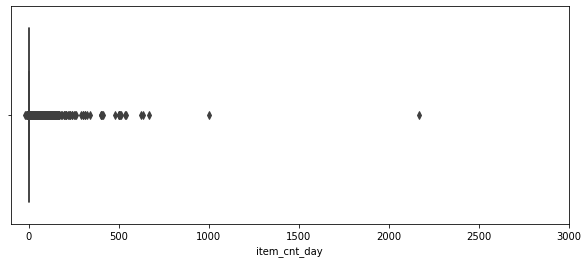

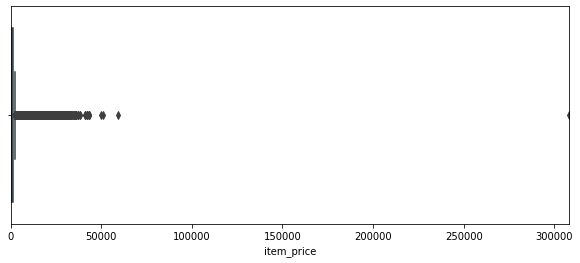

2935849
2
12
1
2935846


In [ ]:
#remove outliers
plt.figure(figsize = (10,4))
plt.xlim(-100, 3000)
sns.boxplot( x= train.item_cnt_day )
plt.figure( figsize = (10,4) )
plt.xlim(train.item_price.min(), train.item_price.max())
sns.boxplot( x = train.item_price )
plt.show()

print(train.shape[0])
print(len( train[train.item_cnt_day >999 ] ))
print( len(train[ train.item_cnt_day > 500  ]) )
print(len(train[train.item_price >100000 ]))
train = train[(train.item_price < 100000 )& (train.item_cnt_day < 1000)]
print(train.shape[0])

In [ ]:
#remove items with price < 0 and set items with count less that 1 to 0
train = train[train.item_price > 0].reset_index(drop = True)
train.loc[train.item_cnt_day < 1, "item_cnt_day"] = 0
print(train.shape)

(2935845, 6)


In [ ]:
train.loc[train.shop_id == 0, "shop_id"] = 57
test.loc[test.shop_id == 0 , "shop_id"] = 57
train.loc[train.shop_id == 1, "shop_id"] = 58
test.loc[test.shop_id == 1 , "shop_id"] = 58
train.loc[train.shop_id == 11, "shop_id"] = 10
test.loc[test.shop_id == 11, "shop_id"] = 10
train.loc[train.shop_id == 40, "shop_id"] = 39
test.loc[test.shop_id == 40, "shop_id"] = 39

In [ ]:
shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
shops["category"] = shops.shop_name.str.split(" ").map( lambda x: x[1] )
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"
category = []
for cat in shops.category.unique():
    print(cat, len(shops[shops.category == cat]) )
    if len(shops[shops.category == cat]) > 4:
        category.append(cat)
shops.category = shops.category.apply( lambda x: x if (x in category) else "etc" )
for cat in shops.category.unique():
    print(cat, len(shops[shops.category == cat]) )

Орджоникидзе, 2
ТЦ 28
ТРК 5
ТРЦ 11
(Плехановская, 1
Торговля 1
ул. 2
ЧС 1
"Распродажа" 1
МТРЦ 1
Магазин 1
ТК 5
склад 1
etc 11
ТЦ 28
ТРК 5
ТРЦ 11
ТК 5


In [ ]:
from sklearn.preprocessing import LabelEncoder
shops["shop_category"] = LabelEncoder().fit_transform( shops.category )
shops["shop_city"] = LabelEncoder().fit_transform( shops.city )
shops = shops[["shop_id", "shop_category", "shop_city"]]

In [ ]:
cats["type_code"] = cats.item_category_name.apply( lambda x: x.split(" ")[0] ).astype(str)
cats.loc[ (cats.type_code == "Игровые")| (cats.type_code == "Аксессуары"), "category" ] = "Игры"
cats.shape
category = []
for cat in cats.type_code.unique():
    print(cat, len(cats[cats.type_code == cat]))
    if len(cats[cats.type_code == cat]) > 4: 
        category.append( cat )
cats.type_code = cats.type_code.apply(lambda x: x if (x in category) else "etc")
for cat in cats.type_code.unique():
    print(cat, len(cats[cats.type_code == cat]))

PC 1
Аксессуары 7
Билеты 1
Доставка 1
Игровые 8
Игры 14
Карты 5
Кино 5
Книги 13
Музыка 6
Подарки 12
Программы 6
Служебные 2
Чистые 2
Элементы 1
etc 8
Аксессуары 7
Игровые 8
Игры 14
Карты 5
Кино 5
Книги 13
Музыка 6
Подарки 12
Программы 6


In [ ]:
cats.type_code = LabelEncoder().fit_transform(cats.type_code)
cats["split"] = cats.item_category_name.apply(lambda x: x.split("-"))
cats["subtype"] = cats.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats["subtype_code"] = LabelEncoder().fit_transform( cats["subtype"] )
cats = cats[["item_category_id", "subtype_code", "type_code"]]

In [ ]:
import re
def name_correction(x):
    x = x.lower()
    x = x.partition('[')[0]
    x = x.partition('(')[0]
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x)
    x = x.replace('  ', ' ')
    x = x.strip()
    return x

In [ ]:
items = pd.read_csv(items_path)

items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
items["name1"], items["name3"] = items.item_name.str.split("(", 1).str

items["name2"] = items.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items["name3"] = items.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items = items.fillna('0')

items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))
items.name2 = items.name2.apply( lambda x: x[:-1] if x !="0" else "0")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  after removing the cwd from sys.path.


In [ ]:
items["type"] = items.name2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") ,"type"] = "xbox 360"
items.loc[ items.type == "", "type"] = "mac"
items.type = items.type.apply( lambda x: x.replace(" ", "") )
items.loc[ (items.type == 'pc' )| (items.type == 'pс') | (items.type == "pc"), "type" ] = "pc"
items.loc[ items.type == 'рs3' , "type"] = "ps3"

In [ ]:
group_sum = items.groupby(["type"]).agg({"item_id": "count"})
print( group_sum.reset_index() )
group_sum = group_sum.reset_index()

        type  item_id
0          0    17661
1        5c5        1
2        5c7        2
3        5f4        1
4        6dv        1
5        6jv        1
6        6l6        1
7    android        3
8        hm3        1
9        j72        4
10       kf6        1
11       kf7        1
12       kg4        1
13       mac       43
14        pc     2628
15        ps       79
16       ps2        2
17       ps3      611
18       ps4      174
19       psp      115
20       s3v        1
21       s4v        1
22   xbox360      466
23   xboxone      123
24      англ        1
25        рс       14
26   русская        1
27    только        9
28     цифро        1
29  цифровая      222


In [ ]:
drop_cols = []
for cat in group_sum.type.unique():
#     print(group_sum.loc[(group_sum.type == cat), "item_id"].values[0])
    if group_sum.loc[(group_sum.type == cat), "item_id"].values[0] <40:
        drop_cols.append(cat)
drop_cols

['5c5',
 '5c7',
 '5f4',
 '6dv',
 '6jv',
 '6l6',
 'android',
 'hm3',
 'j72',
 'kf6',
 'kf7',
 'kg4',
 'ps2',
 's3v',
 's4v',
 'англ',
 'рс',
 'русская',
 'только',
 'цифро']

In [ ]:
items.name2 = items.name2.apply( lambda x: "etc" if (x in drop_cols) else x )
items = items.drop(["type"], axis = 1)
items.name2 = LabelEncoder().fit_transform(items.name2)
items.name3 = LabelEncoder().fit_transform(items.name3)

items.drop(["item_name", "name1"],axis = 1, inplace= True)
items.head()

,item_id,item_category_id,name2,name3
0,0,40,4,1331
1,1,76,64,42
2,2,40,4,1011
3,3,40,4,1010
4,4,40,4,1572


In [ ]:
from itertools import product
import time
ts = time.time()
matrix = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    sales = train[train.date_block_num == i]
    matrix.append( np.array(list( product( [i], sales.shop_id.unique(), sales.item_id.unique() ) ), dtype = np.int16) )

matrix = pd.DataFrame( np.vstack(matrix), columns = cols )
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values( cols, inplace = True )
time.time()- ts

11.15364122390747

In [ ]:
train["revenue"] = train["item_cnt_day"] * train["item_price"]

In [ ]:
ts = time.time()
group = train.groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_day": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True)
matrix = pd.merge( matrix, group, on = cols, how = "left" )
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).clip(0,20).astype(np.float16)
time.time() - ts

4.4390645027160645

In [ ]:
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)
ts = time.time()

matrix = pd.concat([matrix, test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=cols)
matrix.fillna( 0, inplace = True )
time.time() - ts

0.07628464698791504

In [ ]:
ts = time.time()
matrix = pd.merge( matrix, shops, on = ["shop_id"], how = "left" )
matrix = pd.merge(matrix, items, on = ["item_id"], how = "left")
matrix = pd.merge( matrix, cats, on = ["item_category_id"], how = "left" )
matrix["shop_city"] = matrix["shop_city"].astype(np.int8)
matrix["shop_category"] = matrix["shop_category"].astype(np.int8)
matrix["item_category_id"] = matrix["item_category_id"].astype(np.int8)
matrix["subtype_code"] = matrix["subtype_code"].astype(np.int8)
matrix["name2"] = matrix["name2"].astype(np.int8)
matrix["name3"] = matrix["name3"].astype(np.int16)
matrix["type_code"] = matrix["type_code"].astype(np.int8)
time.time() - ts

4.0602126121521

In [ ]:
def lag_feature( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [ ]:
ts = time.time()

matrix = lag_feature( matrix, [1,2,3], ["item_cnt_month"] )
time.time() - ts

item_cnt_month


17.725797176361084

In [ ]:
ts = time.time()
group = matrix.groupby( ["date_block_num"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num"], how = "left")
matrix.date_avg_item_cnt = matrix["date_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1], ["date_avg_item_cnt"] )
matrix.drop( ["date_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

date_avg_item_cnt


9.510670185089111

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix.date_item_avg_item_cnt = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], ['date_item_avg_item_cnt'])
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_avg_item_cnt


22.415313482284546

In [ ]:
ts = time.time()
group = matrix.groupby( ["date_block_num","shop_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_avg_item_cnt"] )
matrix.drop( ["date_shop_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


date_shop_avg_item_cnt


23.045159101486206

In [ ]:
ts = time.time()
group = matrix.groupby( ["date_block_num","shop_id","item_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_item_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id","item_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_item_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_item_avg_item_cnt"] )
matrix.drop( ["date_shop_item_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


date_shop_item_avg_item_cnt


In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix.date_shop_subtype_avg_item_cnt = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_shop_subtype_avg_item_cnt'])
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts


date_shop_subtype_avg_item_cnt


13.20657205581665

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', "shop_city"], how='left')
matrix.date_city_avg_item_cnt = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_city_avg_item_cnt'])
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_city_avg_item_cnt


12.27081823348999

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'shop_city'], how='left')
matrix.date_item_city_avg_item_cnt = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_item_city_avg_item_cnt'])
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_city_avg_item_cnt


19.019996881484985

In [ ]:
ts = time.time()
group = train.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge( group, on = ["item_id"], how = "left" )
matrix["item_avg_item_price"] = matrix.item_avg_item_price.astype(np.float16)


group = train.groupby( ["date_block_num","item_id"] ).agg( {"item_price": ["mean"]} )
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge(group, on = ["date_block_num","item_id"], how = "left")
matrix["date_item_avg_item_price"] = matrix.date_item_avg_item_price.astype(np.float16)
lags = [1, 2, 3]
matrix = lag_feature( matrix, lags, ["date_item_avg_item_price"] )
for i in lags:
    matrix["delta_price_lag_" + str(i) ] = (matrix["date_item_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"]

def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

matrix["delta_price_lag"] = matrix.apply(select_trends, axis = 1)
matrix["delta_price_lag"] = matrix.delta_price_lag.astype( np.float16 )
matrix["delta_price_lag"].fillna( 0 ,inplace = True)

features_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
for i in lags:
    features_to_drop.append("date_item_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)
time.time() - ts

date_item_avg_item_price


305.2557158470154

In [ ]:

ts = time.time()
group = train.groupby( ["date_block_num","shop_id"] ).agg({"revenue": ["sum"] })
group.columns = ["date_shop_revenue"]
group.reset_index(inplace = True)

matrix = matrix.merge( group , on = ["date_block_num", "shop_id"], how = "left" )
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(["shop_id"]).agg({ "date_block_num":["mean"] })
group.columns = ["shop_avg_revenue"]
group.reset_index(inplace = True )

matrix = matrix.merge( group, on = ["shop_id"], how = "left" )
matrix["shop_avg_revenue"] = matrix.shop_avg_revenue.astype(np.float32)
matrix["delta_revenue"] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix["delta_revenue"] = matrix["delta_revenue"]. astype(np.float32)

matrix = lag_feature(matrix, [1], ["delta_revenue"])
matrix["delta_revenue_lag_1"] = matrix["delta_revenue_lag_1"].astype(np.float32)
matrix.drop( ["date_shop_revenue", "shop_avg_revenue", "delta_revenue"] ,axis = 1, inplace = True)
time.time() - ts

delta_revenue


13.684904336929321

In [ ]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,type_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_item_avg_item_cnt_lag_1,date_shop_item_avg_item_cnt_lag_2,date_shop_item_avg_item_cnt_lag_3,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1
0,0,2,19,0.0,4,0,40,4,42,4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
1,0,2,27,1.0,4,0,19,76,42,10,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
2,0,2,28,0.0,4,0,30,107,42,55,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
3,0,2,29,0.0,4,0,23,123,42,16,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
4,0,2,32,0.0,4,0,40,4,42,4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,34,45,18454,0.0,4,20,55,4,42,2,7,1.0,0.0,0.0,0.259033,0.045441,0.023254,0.071411,0.126709,0.129395,0.13916,1.0,0.0,0.0,0.135376,0.5,-0.475098,51790.574219
11056273,34,45,16188,0.0,4,20,64,4,42,42,8,0.0,0.0,NaN,0.259033,0.022720,0.069763,NaN,0.126709,0.129395,NaN,0.0,0.0,NaN,0.135376,0.0,0.081116,51790.574219
11056274,34,45,15757,0.0,4,20,55,4,42,2,7,0.0,0.0,0.0,0.259033,0.113647,0.069763,0.095215,0.126709,0.129395,0.13916,0.0,0.0,0.0,0.135376,0.0,0.155884,51790.574219
11056275,34,45,19648,0.0,4,20,40,4,1367,4,5,0.0,0.0,0.0,0.259033,0.045441,0.069763,0.166626,0.126709,0.129395,0.13916,0.0,0.0,0.0,0.135376,0.0,-0.091736,51790.574219


In [ ]:
matrix.head().T

,0,1,2,3,4
date_block_num,0.0,0.0,0.0,0.0,0.0
shop_id,2.0,2.0,2.0,2.0,2.0
item_id,19.0,27.0,28.0,29.0,32.0
item_cnt_month,0.0,1.0,0.0,0.0,0.0
shop_category,4.0,4.0,4.0,4.0,4.0
shop_city,0.0,0.0,0.0,0.0,0.0
item_category_id,40.0,19.0,30.0,23.0,40.0
name2,4.0,76.0,107.0,123.0,4.0
name3,42.0,42.0,42.0,42.0,42.0
subtype_code,4.0,10.0,55.0,16.0,4.0


In [ ]:
matrix["month"] = matrix["date_block_num"] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix["days"] = matrix["month"].map(days).astype(np.int8)

In [ ]:
ts = time.time()
matrix["item_shop_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id","shop_id"])["date_block_num"].transform('min')
matrix["item_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id"])["date_block_num"].transform('min')
time.time() - ts

1.6975736618041992

In [ ]:
ts = time.time()
matrix = matrix[matrix["date_block_num"] > 3]
time.time() - ts

0.9104199409484863

In [ ]:
import os
import gc
import pickle
import time
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [ ]:
data = matrix.copy()
del matrix
gc.collect()

22

In [ ]:
data[data["date_block_num"]==34].shape

(214200, 32)

In [ ]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)


In [ ]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    #start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    #end_mem = df.memory_usage().sum() / 1024**2
    #if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
X_train = reduce_mem_usage(pd.DataFrame(X_train))
Y_train = reduce_mem_usage(pd.DataFrame(Y_train))
X_valid = reduce_mem_usage(pd.DataFrame(X_valid))
Y_valid = reduce_mem_usage(pd.DataFrame(Y_valid))
X_test = reduce_mem_usage(pd.DataFrame(X_test))
y_train=Y_train

In [ ]:
X_test.shape

(214200, 31)

In [ ]:
del data



gc.collect();

In [ ]:
# categorical_features = (data.dtypes[data.dtypes.apply(str).str.startswith('int')].index).tolist()
  categorical_features = ['item_category_id',
  'shop_id']

In [ ]:
!pip install lofo-importance
!pip install pandarallel

In [ ]:
!pip install bayesian-optimization
!pip install scikit-optimize
from bayes_opt import BayesianOptimization
from skopt  import BayesSearchCV 

yT = Y_train['item_cnt_month'].values.astype(np.int32)

def bayes_parameter_opt_lgb(X_train, yT, init_round=15, opt_round=25, n_folds=3, random_seed=6,n_estimators=10000, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X_train, label=yT, free_raw_data=False)
    # parameters
    def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample,bagging_seed,feature_fraction_seed,bagging_freq):
        params = {'application':'binary', 'metric':'auc'}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params["num_leaves"] = int(round(num_leaves))
        params['bagging_seed'] = int(round(bagging_seed))
        params['bagging_freq'] = int(round(bagging_freq))
        params['feature_fraction_seed'] = int(round(feature_fraction_seed))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)


        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['max_bin'] = int(round(max_depth))
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
        params['subsample'] = max(min(subsample, 1), 0)
        
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
     
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.006, 0.009),
                                            'num_leaves': (200, 350),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.3, 1),
                                            'max_depth': (5, 80),
                                            'max_bin':(150,350),
                                             'bagging_seed' : (0,1),
                                            'min_data_in_leaf': (5, 10),
                                            'min_sum_hessian_in_leaf':(0,10),
                                            'bagging_freq':(0.5, 1),
                                             'feature_fraction_seed':( 0,1),
                                           'subsample': (0.01, 1.0)}, random_state=42)

    # params = {'num_leaves': 256, 'max_depth': 19, 'max_bin': 250, 'n_estimators': 5000,
    #           'bagging_freq': 1, 'bagging_fraction': 0.99, 
    #           'feature_fraction': 0.49446461478601994, 'min_data_in_leaf': 6, # 88
    #           'learning_rate': 0.00762, 'num_threads': 16,
    #           'min_sum_hessian_in_leaf': 6,
    #           'random_state' : RAND_SEED,
    #           'bagging_seed' : 0,
    #           'feature_fraction_seed': 0,
    #           'boost_from_average' : 'true',
    #           'boost' : 'gbdt',
    #           'metric' : 'rmse',
    #           'verbose' : 1}
    #n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
    #init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
    
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    model_auc=[]
    for model in range(len( lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])
    
    # return best parameters
    return lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']

opt_params = bayes_parameter_opt_lgb(X_train, yT, init_round=5, opt_round=10, n_folds=3, random_seed=6,n_estimators=10000)

|   iter    |  target   | baggin... | baggin... | baggin... | featur... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8613   |  0.5622   |  0.9754   |  0.732    |  0.5789   |  0.156    |  0.006468 |  161.6    |  69.96    |  8.006    |  7.081    |  203.1    |  0.9702   |
|  2        |  0.858    |  0.8827   |  0.6062   |  0.1818   |  0.2467   |  0.3042   |  0.007574 |  236.4    |  26.84    |  8.059    |  1.395    |  243.8    |  0.3727   |
|  3        |  0.8643   |  0.6192   |  0.8926   |  0.1997   |  0.5114   |  0.5924   |  0.006139 |  271.5    |  17.79    |  5.325    |  9.489    |  344.8    |  0.8103   |
|  4        |  0.8624   |  0.5132   |  0.5488   |  0.6842   |  0.4521   |  0.122    |  0.007486 |  156.9    |  73.2     |  6.294    |  6.625    |  246

In [ ]:
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params=opt_params[1]
opt_params

{'bagging_fraction': 0.9639589902207968,
 'bagging_freq': 0.5979448513249741,
 'bagging_seed': 0.5341475068107697,
 'feature_fraction': 0.7449874222314683,
 'feature_fraction_seed': 0.8209781239992309,
 'learning_rate': 0.008784729562129227,
 'max_bin': 157,
 'max_depth': 78,
 'min_data_in_leaf': 6,
 'min_sum_hessian_in_leaf': 0.3239855257428115,
 'num_leaves': 350,
 'subsample': 0.8880567272018562}

In [ ]:


import numpy as np
import pandas as pd
import dateutil
import datetime as dt
from datetime import date
from pandarallel import pandarallel
import matplotlib.pyplot as plt
import seaborn as sns
import re
import gc
from tqdm.notebook import tqdm
import pickle
import statsmodels.api as sm
from pylab import rcParams
from itertools import permutations, product
import time
import lightgbm as lgb
import random
from lightgbm import LGBMRegressor
from lofo import LOFOImportance, FLOFOImportance, Dataset, plot_importance
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.metrics import (mean_squared_log_error, mean_squared_error,
                             mean_absolute_error)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split, KFold
import warnings

pandarallel.initialize()
ts = time.time()

kf = KFold(n_splits = 5, random_state=42)
resu1 = 0
impor1 = 0
resu3_mae=0
y_pred = 0
y_final_test = 0
stack_train = np.zeros([X_train.shape[0], ])
models = []
# params = {'num_leaves': 70,
#           'objective': 'regression',
#           'learning_rate': 0.1,
#           "boosting": "dart",
#           "bagging_freq": 5,
#           "bagging_fraction": 0.1,
#           "feature_fraction": 0.9,
#           "num_rounds": 600,
#           # 'max_depth':10
#           }

# RAND_SEED = 42

# params = {'num_leaves': 2**8, #'max_depth': 19, 'max_bin': 107, #'n_estimators': 3747,
#               'bagging_freq': 1, 'bagging_fraction': 0.7135681370918421, 
#               'feature_fraction': 0.49446461478601994, #'min_data_in_leaf': 2**8, # 88
#               'learning_rate': 0.015980721586917768, 'num_threads': 4, 
#               'min_sum_hessian_in_leaf': 6,
#               'random_state' : RAND_SEED,
#               'bagging_seed' : RAND_SEED,
#               'boost_from_average' : 'true',
#               'boost' : 'dart',
#               'metric' : 'rmse',
#               'verbose' : 1}
# params = {'num_leaves': 2**8, 'max_depth': 19, 'max_bin': 350, 'n_estimators': 3747,
#               'bagging_freq': 1, 'bagging_fraction': 0.71, 
#               'feature_fraction': 0.49, 'min_data_in_leaf': 2**8, # 88
#               'learning_rate': 0.015, 'num_threads': 4, 
#               'min_sum_hessian_in_leaf': 6,
#               'random_state' : RAND_SEED,
#               'bagging_seed' : RAND_SEED,
#               'boost_from_average' : 'true',
#               'boost' : 'gbdt',
#               'metric' : 'rmse',
#               'verbose' : 1}
# params = {'num_leaves': 2**8, 'max_depth': 19, 'max_bin': 300, 'n_estimators': 3747,
#               'bagging_freq': 1, 'bagging_fraction': 0.7135681370918421, 
#               'feature_fraction': 0.49446461478601994, 'min_data_in_leaf': 2**8, # 88
#               'learning_rate': 0.015980721586917768, 'num_threads': 4, 
#               'min_sum_hessian_in_leaf': 6,
#               'random_state' : RAND_SEED,
#               'bagging_seed' : RAND_SEED,
#               'boost_from_average' : 'true',
#               'boost' : 'dart',
#               'metric' : 'rmse',
#               'verbose' : 1}

# params = {'num_leaves': 2**8,  'max_bin': 270, #'n_estimators': 3747,
#               'bagging_freq': 1, 'bagging_fraction': 0.7135681370918421, 
#               'feature_fraction': 0.49446461478601994, 'min_data_in_leaf': 2**8, # 88
#               'learning_rate': 0.0015, 'num_threads': 4, 
#               'min_sum_hessian_in_leaf': 6,
#               'random_state' : RAND_SEED,
#               'bagging_seed' : RAND_SEED,
#               'boost_from_average' : 'true',
#               'boost' : 'gbdt',
#               'metric' : 'rmse',
#               'verbose' : 1}
# params={"early_stopping_rounds":30, 
#             "eval_metric" : 'rmse', 
#             'learning_rate': 0.015980721586917768,
#             'verbose': 100,
#             # 'categorical_feature': 'auto',
#            'num_leaves': random.randint(6, 50), 
#             #  'min_child_samples': sp_randint(100, 500), 
#             #  'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#             #  'subsample': sp_uniform(loc=0.2, scale=0.8), 
#             #  'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
#             #  'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#             #  'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
# 'max_depth':-1, 'random_state':314, 'n_jobs':4, 'n_estimators':5000}
# # params = { "objective" : "regression", "metric" : "rmse", 'n_estimators':10000, 'early_stopping_rounds':100,
# #               "num_leaves" : 150, "learning_rate" : 0.015, "bagging_fraction" : 0.49,
# #               "feature_fraction" : 0.3, "bagging_seed" : RAND_SEED,'boost' : 'dart',}
    #try thiss
RAND_SEED = 42
# params = {'nthread': 4,
#           'objective':'regression', 
#             'n_estimators': 7000,
#             'learning_rate': .01,
#             'num_leaves': 6,
#           'max_bin':200,
#           'bagging_fraction': 0.8,
#           'bagging_freq': 4,
#           'bagging_seed':8,
#           'feature_fraction':0.2,
#             'feature_fraction_seed':8,
#           'min_sum_hessian_in_leaf': 11,
#           'random_state':42,
#             'verbose': -1,
          
#               'metric' : 'rmse',}
# params = {'num_leaves': 256, 'max_depth': 19, 'max_bin': 250, 'n_estimators': 5000,
#               'bagging_freq': 1, 'bagging_fraction': 0.99, 
#               'feature_fraction': 0.49446461478601994, 'min_data_in_leaf': 6, # 88
#               'learning_rate': 0.00762, 'num_threads': 16,
#               'min_sum_hessian_in_leaf': 6,
#               'random_state' : RAND_SEED,
#               'bagging_seed' : 0,
#               'feature_fraction_seed': 0,
#               'boost_from_average' : 'true',
#               'boost' : 'gbdt',
#               'metric' : 'rmse',
#               'verbose' : 1}

params={'bagging_fraction': 0.9639589902207968,
 'bagging_freq': 1,
 'bagging_seed': 0,
 'feature_fraction':0.49446461478601994,
 'feature_fraction_seed': 1,
 'learning_rate': 0.00762,
 'max_bin': 257,
 'max_depth': 19,
 'min_data_in_leaf': 6,

 'num_leaves': 256,

 'boost_from_average' : 'true',
              'boost' : 'gbdt',
              'metric' : 'rmse',
              'verbose' : 1,'n_estimators': 5000, 'random_state' : RAND_SEED}
# {'num_leaves': 2**8, #'max_depth': 19, 
#           'max_bin': 250, 
#           'n_estimators': 5000,
#               'bagging_freq': 1, 'bagging_fraction':  0.9639589902207968, 
#               'feature_fraction': 0.49446461478601994, #'min_data_in_leaf': 2**8, # 88
#               'learning_rate': 0.0075,
#           'min_data_in_leaf': 5,
#                'num_threads': 16, 
#                 #'device' : 'gpu',
#               'min_sum_hessian_in_leaf': 6,
#               'random_state' : RAND_SEED,
#               'bagging_seed' : 0,
#               'boost_from_average' : 'true',
#               'metric' : 'rmse',
#               'verbose' : 1}
# # params = {

#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'learning_rate': 0.035,
#     'metric': 'rmse',
#     'is_training_metric' : True,
#     'tree_leaner': 'data',
#     'feature_fraction_seed' : 42,
#     'verbose':0,
#     'feature_fraction':0.85,
#     'bagging_fraction': 0.45,
#     'bagging_freq':7,
#     # 'bagging_seed': 42,
#     'l2_lambda':14,
#     #'l1_lambda': 16,
#     'num_leaves': 1024,
#     'min_data_in_leaf':40,
#     'min_gain_to_split':1,
#     # 'max_bin' :300
# }
          
for train_index, test_index in tqdm(list(kf.split(X_train, y_train))):
    X_train2 = X_train.iloc[train_index, :]
    y_train2 = y_train.iloc[train_index]
    X_test2 = X_train.iloc[test_index, :]
    y_test2 = y_train.iloc[test_index]
    
    d_training = lgb.Dataset(X_train2, label=y_train2,
                             categorical_feature=categorical_features,
                             free_raw_data=False)
    d_test = lgb.Dataset(X_test2, label=y_test2,
                         categorical_feature=categorical_features,
                         free_raw_data=False)
    
    clf = lgb.train(params, train_set=d_training, num_boost_round=1000,
                      valid_sets=[d_training, d_test], verbose_eval=25,
                      early_stopping_rounds=100
                    )

    models.append(clf)
    temp_predict = clf.predict(X_test2, num_iteration=clf.best_iteration)
    stack_train[test_index] = temp_predict

    y_pred += clf.predict(X_test, num_iteration=clf.best_iteration)/5
    y_final_test += clf.predict(X_test, num_iteration=clf.best_iteration)/5
    mse = mean_squared_error(y_test2, temp_predict)
    mae = mean_absolute_error(y_test2, temp_predict)

    resu1 += mse/5
    resu3_mae += mae/5
    impor1 += clf.feature_importance()/5
    del X_train2, y_train2, X_test2, y_test2; gc.collect()

print('xxxxxxxxx',resu1,resu3_mae)
# model = lgb.LGBMRegressor(**params)


# # model = XGBRegressor(
# #     max_depth=10,
# #     n_estimators=1000,
# #     min_child_weight=0.5, 
# #     colsample_bytree=0.8, 
# #     subsample=0.8, 
# #     eta=0.1,
# #      tree_method='gpu_hist',
# #     seed=42)
# # X_valid=X_train.iloc[train_index, :]
# model.fit(
#     X_train, 
#     Y_train, 

#     eval_metric="rmse", 
#     eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
#     verbose=True, )
#     # early_stopping_rounds = 50)

time.time() - ts

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[25]	training's rmse: 1.1391	valid_1's rmse: 1.09294
[50]	training's rmse: 1.06524	valid_1's rmse: 1.03678
[75]	training's rmse: 1.00635	valid_1's rmse: 0.993125
[100]	training's rmse: 0.961353	valid_1's rmse: 0.960745
[125]	training's rmse: 0.927024	valid_1's rmse: 0.936818
[150]	training's rmse: 0.900496	valid_1's rmse: 0.918813
[175]	training's rmse: 0.87907	valid_1's rmse: 0.904958
[200]	training's rmse: 0.862032	valid_1's rmse: 0.894309
[225]	training's rmse: 0.84823	valid_1's rmse: 0.886468
[250]	training's rmse: 0.836825	valid_1's rmse: 0.879867
[275]	training's rmse: 0.827249	valid_1's rmse: 0.874897
[300]	training's rmse: 0.818981	valid_1's rmse: 0.871184
[325]	training's rmse: 0.812251	valid_1's rmse: 0.867995
[350]	training's rmse: 0.806061	valid_1's rmse: 0.865454
[375]	training's rmse: 0.800818	valid_1's rmse: 0.863332
[400]	training's rmse: 0.795929	valid_1's rmse: 0.861577
[425]	training's rmse: 0.791341	vali

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[25]	training's rmse: 1.09631	valid_1's rmse: 1.25721
[50]	training's rmse: 1.02703	valid_1's rmse: 1.18384
[75]	training's rmse: 0.971912	valid_1's rmse: 1.12511
[100]	training's rmse: 0.929929	valid_1's rmse: 1.08048
[125]	training's rmse: 0.897742	valid_1's rmse: 1.04856
[150]	training's rmse: 0.872936	valid_1's rmse: 1.02387
[175]	training's rmse: 0.852977	valid_1's rmse: 1.00506
[200]	training's rmse: 0.837173	valid_1's rmse: 0.991012
[225]	training's rmse: 0.824258	valid_1's rmse: 0.980506
[250]	training's rmse: 0.813482	valid_1's rmse: 0.972381
[275]	training's rmse: 0.804516	valid_1's rmse: 0.96591
[300]	training's rmse: 0.796732	valid_1's rmse: 0.960898
[325]	training's rmse: 0.790252	valid_1's rmse: 0.957157
[350]	training's rmse: 0.784327	valid_1's rmse: 0.953729
[375]	training's rmse: 0.779299	valid_1's rmse: 0.951165
[400]	training's rmse: 0.774528	valid_1's rmse: 0.949049
[425]	training's rmse: 0.770141	valid_

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[25]	training's rmse: 1.14491	valid_1's rmse: 1.06504
[50]	training's rmse: 1.07227	valid_1's rmse: 1.00172
[75]	training's rmse: 1.01449	valid_1's rmse: 0.952549
[100]	training's rmse: 0.97015	valid_1's rmse: 0.91592
[125]	training's rmse: 0.936286	valid_1's rmse: 0.889148
[150]	training's rmse: 0.910151	valid_1's rmse: 0.869374
[175]	training's rmse: 0.889045	valid_1's rmse: 0.854515
[200]	training's rmse: 0.872364	valid_1's rmse: 0.843324
[225]	training's rmse: 0.858772	valid_1's rmse: 0.835225
[250]	training's rmse: 0.847595	valid_1's rmse: 0.828328
[275]	training's rmse: 0.838207	valid_1's rmse: 0.822998
[300]	training's rmse: 0.830053	valid_1's rmse: 0.81911
[325]	training's rmse: 0.823325	valid_1's rmse: 0.815826
[350]	training's rmse: 0.817132	valid_1's rmse: 0.812912
[375]	training's rmse: 0.811774	valid_1's rmse: 0.810844
[400]	training's rmse: 0.806842	valid_1's rmse: 0.809106
[425]	training's rmse: 0.802138	vali

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[25]	training's rmse: 1.10123	valid_1's rmse: 1.24023
[50]	training's rmse: 1.03177	valid_1's rmse: 1.16858
[75]	training's rmse: 0.976831	valid_1's rmse: 1.11051
[100]	training's rmse: 0.934683	valid_1's rmse: 1.06581
[125]	training's rmse: 0.902476	valid_1's rmse: 1.03365
[150]	training's rmse: 0.877881	valid_1's rmse: 1.00853
[175]	training's rmse: 0.858002	valid_1's rmse: 0.98829
[200]	training's rmse: 0.842294	valid_1's rmse: 0.973626
[225]	training's rmse: 0.829399	valid_1's rmse: 0.962402
[250]	training's rmse: 0.818665	valid_1's rmse: 0.953218
[275]	training's rmse: 0.809777	valid_1's rmse: 0.946477
[300]	training's rmse: 0.802062	valid_1's rmse: 0.941032
[325]	training's rmse: 0.795613	valid_1's rmse: 0.936483
[350]	training's rmse: 0.789695	valid_1's rmse: 0.932646
[375]	training's rmse: 0.784565	valid_1's rmse: 0.929733
[400]	training's rmse: 0.779803	valid_1's rmse: 0.927382
[425]	training's rmse: 0.775326	valid

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[25]	training's rmse: 1.15837	valid_1's rmse: 0.997724
[50]	training's rmse: 1.08397	valid_1's rmse: 0.937942
[75]	training's rmse: 1.02482	valid_1's rmse: 0.892973
[100]	training's rmse: 0.979376	valid_1's rmse: 0.860864
[125]	training's rmse: 0.944714	valid_1's rmse: 0.837844
[150]	training's rmse: 0.917969	valid_1's rmse: 0.821445
[175]	training's rmse: 0.896446	valid_1's rmse: 0.809461
[200]	training's rmse: 0.87945	valid_1's rmse: 0.801104
[225]	training's rmse: 0.865565	valid_1's rmse: 0.795735
[250]	training's rmse: 0.854042	valid_1's rmse: 0.791572
[275]	training's rmse: 0.844497	valid_1's rmse: 0.788574
[300]	training's rmse: 0.836165	valid_1's rmse: 0.786875
[325]	training's rmse: 0.829203	valid_1's rmse: 0.785448
[350]	training's rmse: 0.822844	valid_1's rmse: 0.784418
[375]	training's rmse: 0.817349	valid_1's rmse: 0.783787
[400]	training's rmse: 0.812295	valid_1's rmse: 0.783246
[425]	training's rmse: 0.807629	

2611.5011653900146

In [ ]:
test_df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/ML Project/Dataset/Original_Source/test.csv')
# # submission=pd.DataFrame
# submission=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/ML Project/Dataset/Original_Source/submission (2).csv')

# for i in submission:
#   print(i)

# # for i in range(214200):
# #   if i in good_pairs['ID']:
# #     df1=pd.DataFrame({
# #         "ID": i, 
# #         "item_cnt_month": [y_final_test[i]]})
# #     submission.append(df1)
# #   else:
# #     df1=pd.DataFrame({"ID": i, 
# #     "item_cnt_month": [0]})
# #     submission.append(df1)
# # print(submission)
# 
submission = pd.DataFrame({
    "ID": test_df.index, 
    "item_cnt_month": y_final_test
})
submission.to_csv('final9.csv', index=False)

In [ ]:
!kill -9 -1